In [1]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.lag_llama.gluon.estimator import LagLlamaEstimator

/home/vitvara/Documents/forecasting/.venv/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [2]:
def get_lag_llama_predictions(dataset, prediction_length, num_samples=100):
    ckpt = torch.load("model_ckpt/lag-llama.ckpt", map_location=torch.device('cpu')) # Uses GPU since in this Colab we use a GPU.
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    estimator = LagLlamaEstimator(
        ckpt_path="model_ckpt/lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=prediction_length*3, # Should not be changed; this is what the released Lag-Llama model was trained with

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

In [3]:
import pandas as pd
from gluonts.dataset.pandas import PandasDataset

url = (
    "https://gist.githubusercontent.com/rsnirwan/a8b424085c9f44ef2598da74ce43e7a3"
    "/raw/b6fdef21fe1f654787fa0493846c546b7f9c4df2/ts_long.csv"
)
df = pd.read_csv('data/result.csv', index_col=0, parse_dates=True)


/tmp/ipykernel_224842/4012655465.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('data/result.csv', index_col=0, parse_dates=True)


In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [5]:
df = df[['fund_name', 'nav/unit', 'date']]

In [6]:
valid = [group.fund_name.unique()[0] for _, group in df.groupby('fund_name') if group.date.min() <= '2012-01-01']

In [7]:
df = df[df.fund_name.isin(valid)]

In [8]:
min_date = max([group.date.min() for _, group in df.groupby('fund_name')])
max_date = min([group.date.max() for _, group in df.groupby('fund_name')])
min_date, max_date, [group.date.min() for _, group in df.groupby('fund_name')]

('2011-02-17',
 '2024-01-16',
 ['2010-01-04',
  '2010-01-04',
  '2010-01-04',
  '2010-01-04',
  '2010-01-04',
  '2010-01-04',
  '2010-01-04',
  '2010-01-04',
  '2010-01-04',
  '2010-01-04',
  '2011-02-17',
  '2010-01-04',
  '2010-01-04',
  '2010-05-19',
  '2010-05-19',
  '2010-01-04',
  '2010-01-04',
  '2010-01-04',
  '2010-01-04',
  '2010-01-04',
  '2010-01-04',
  '2010-01-04',
  '2010-01-04'])

In [9]:
df = df[(df.date >= min_date) & (df.date <= max_date)]

In [10]:
date_range = pd.DataFrame(pd.date_range(start=min_date, end=max_date), columns=['date'])

In [11]:
df.date = pd.to_datetime(df.date)

In [12]:
from sklearn.preprocessing import MinMaxScaler
container = []
for _, group in df.groupby('fund_name'):
    group = group.sort_values('date')
    group = group.merge(date_range, on='date', how='left')
    group['nav/unit'] = group['nav/unit'].replace(0, None)
    group['nav/unit'] = group['nav/unit'].ffill().bfill()
    group['nav/unit'] = MinMaxScaler((10e-10,1)).fit_transform(group[['nav/unit']])
    group.index = pd.to_datetime(group['date'])
    result = seasonal_decompose(group['nav/unit'], model='multiplicative', period=30)
    group['trend'] = result.trend
    group['seasonal'] = result.seasonal
    group['resid'] = result.resid
    container.append(group)
df= pd.concat(container)

In [13]:
df.index = df.date

In [14]:
df = df[['fund_name', 'nav/unit', 'trend', 'seasonal', 'resid', 'date']]

In [15]:
df['nav/unit'] = df['nav/unit'].astype('float32')
df['trend'] = df['trend'].astype('float32')
df['seasonal'] = df['seasonal'].astype('float32')
df['resid'] = df['resid'].astype('float32')

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72356 entries, 2011-02-17 to 2024-01-16
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   fund_name  72356 non-null  object        
 1   nav/unit   72356 non-null  float32       
 2   trend      71666 non-null  float32       
 3   seasonal   72356 non-null  float32       
 4   resid      71666 non-null  float32       
 5   date       72356 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float32(4), object(1)
memory usage: 2.8+ MB


In [101]:
groups = [i[1].index.max() for i in list(df.groupby('fund_name'))]

In [16]:
df = df.sort_index()

In [106]:
# Set numerical columns as float32

target = 'seasonal'
# Create the Pandas
dataset = PandasDataset.from_long_dataframe(df[[target, 'date', 'fund_name']].dropna(), unchecked=True, timestamp='date', target=target, item_id="fund_name", freq='D')

backtest_dataset = dataset
prediction_length = 30  # Define your prediction length. We use 24 here since the data is of hourly frequency
num_samples = 90 # number of samples sampled from the probability distribution for each timestep

In [107]:
forecasts, tss = get_lag_llama_predictions(backtest_dataset, prediction_length)

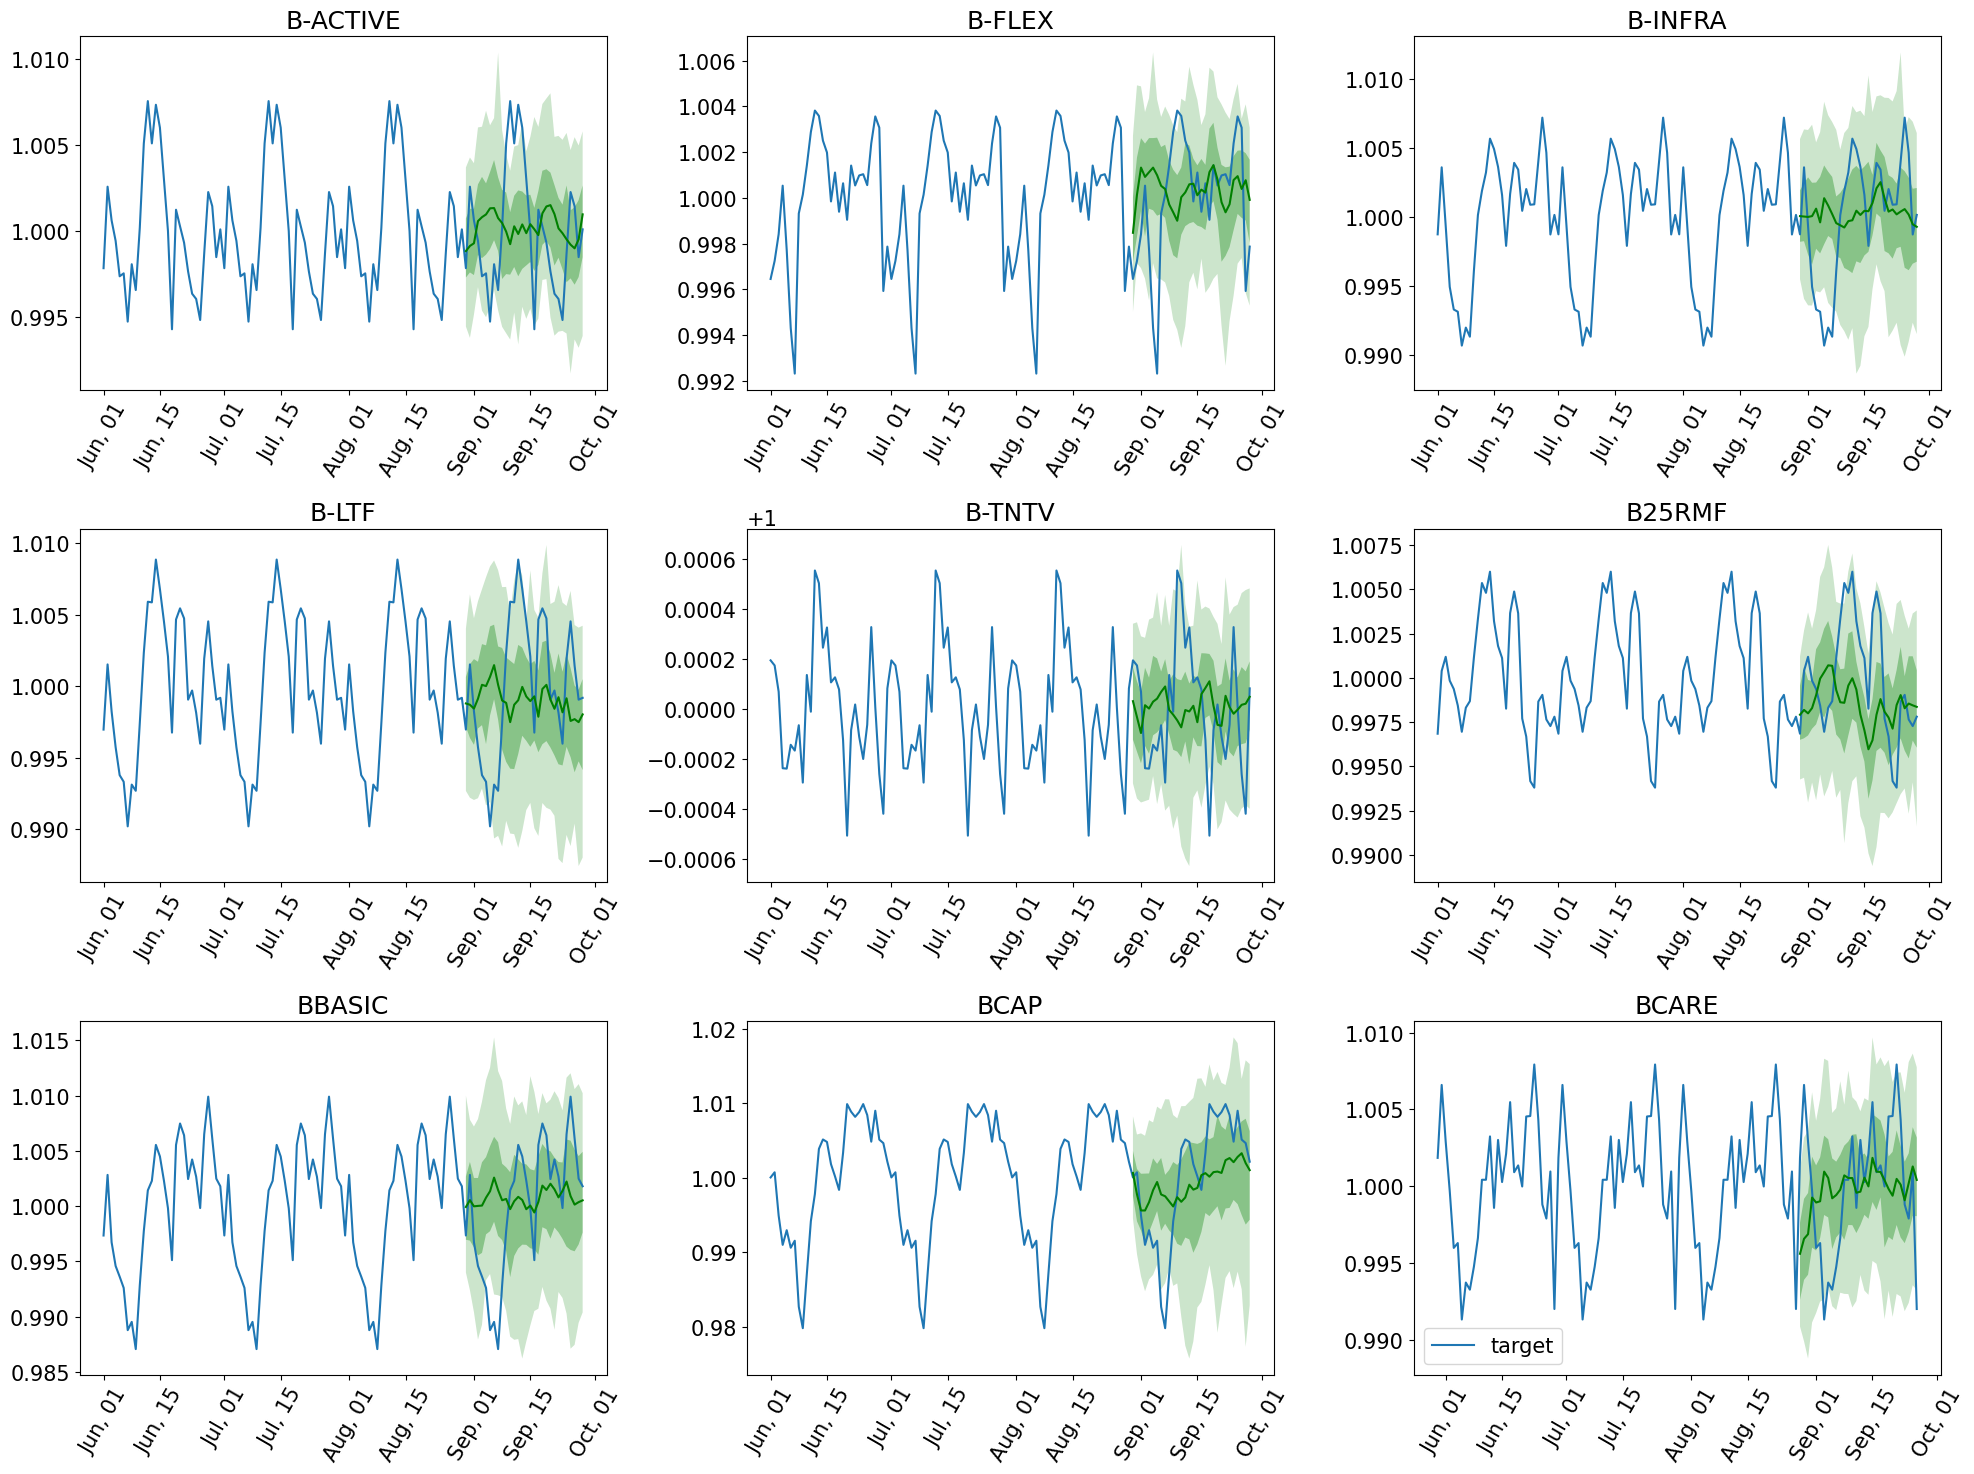

In [108]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [22]:
ckpt = torch.load("model_ckpt/lag-llama.ckpt", map_location=torch.device('cuda')) # Uses GPU since in this Colab we use a GPU.
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]


estimator = LagLlamaEstimator(
        ckpt_path="model_ckpt/lag-llama.ckpt",
        prediction_length=60,
        context_length=60*3,

        # distr_output="neg_bin",
        # scaling="mean",
        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=5e-4,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],

        # rope_scaling={
        #     "type": "linear",
        #     "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        # },

        batch_size=32,
        num_parallel_samples=100,
        trainer_kwargs = {"max_epochs": 50,}, # <- lightning trainer arguments
    )

In [17]:
target = 'seasonal'
train_group = list(df[[target, 'date', 'fund_name']].groupby('fund_name'))
train_df = pd.concat([group.dropna().iloc[:-30] for _, group in train_group])

In [18]:
test_group = df[[target, 'date', 'fund_name']].groupby('fund_name')
test_df = pd.concat([group.dropna() for _, group in test_group])

In [20]:
# Create the Pandas
dataset_train = PandasDataset.from_long_dataframe(train_df, unchecked=True, timestamp='date', target=target, item_id="fund_name", freq='D')
dataset_test = PandasDataset.from_long_dataframe(test_df, unchecked=True, timestamp='date', target=target, item_id="fund_name", freq='D')

In [23]:
predictor = estimator.train(dataset_train, cache_data=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/vitvara/Documents/forecasting/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/home/vitvara/Documents/forecasting/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To pr

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached -0.05852 (best -0.05852), saving model to '/home/vitvara/Documents/forecasting/lightning_logs/version_5/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached -0.99447 (best -0.99447), saving model to '/home/vitvara/Documents/forecasting/lightning_logs/version_5/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached -2.00157 (best -2.00157), saving model to '/home/vitvara/Documents/forecasting/lightning_logs/version_5/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached -2.31461 (best -2.31461), saving model to '/home/vitvara/Documents/forecasting/lightning_logs/version_5/checkpoints/epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached -2.31815 (best -2.31815), saving model to '/home/vitvara/Documents/forecasting/lightning_logs/version_5/checkpoints/epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: '

In [24]:
forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset_test,
        predictor=predictor,
        num_samples=100
    )

In [25]:
forecasts = list(forecast_it)
tss = list(ts_it)

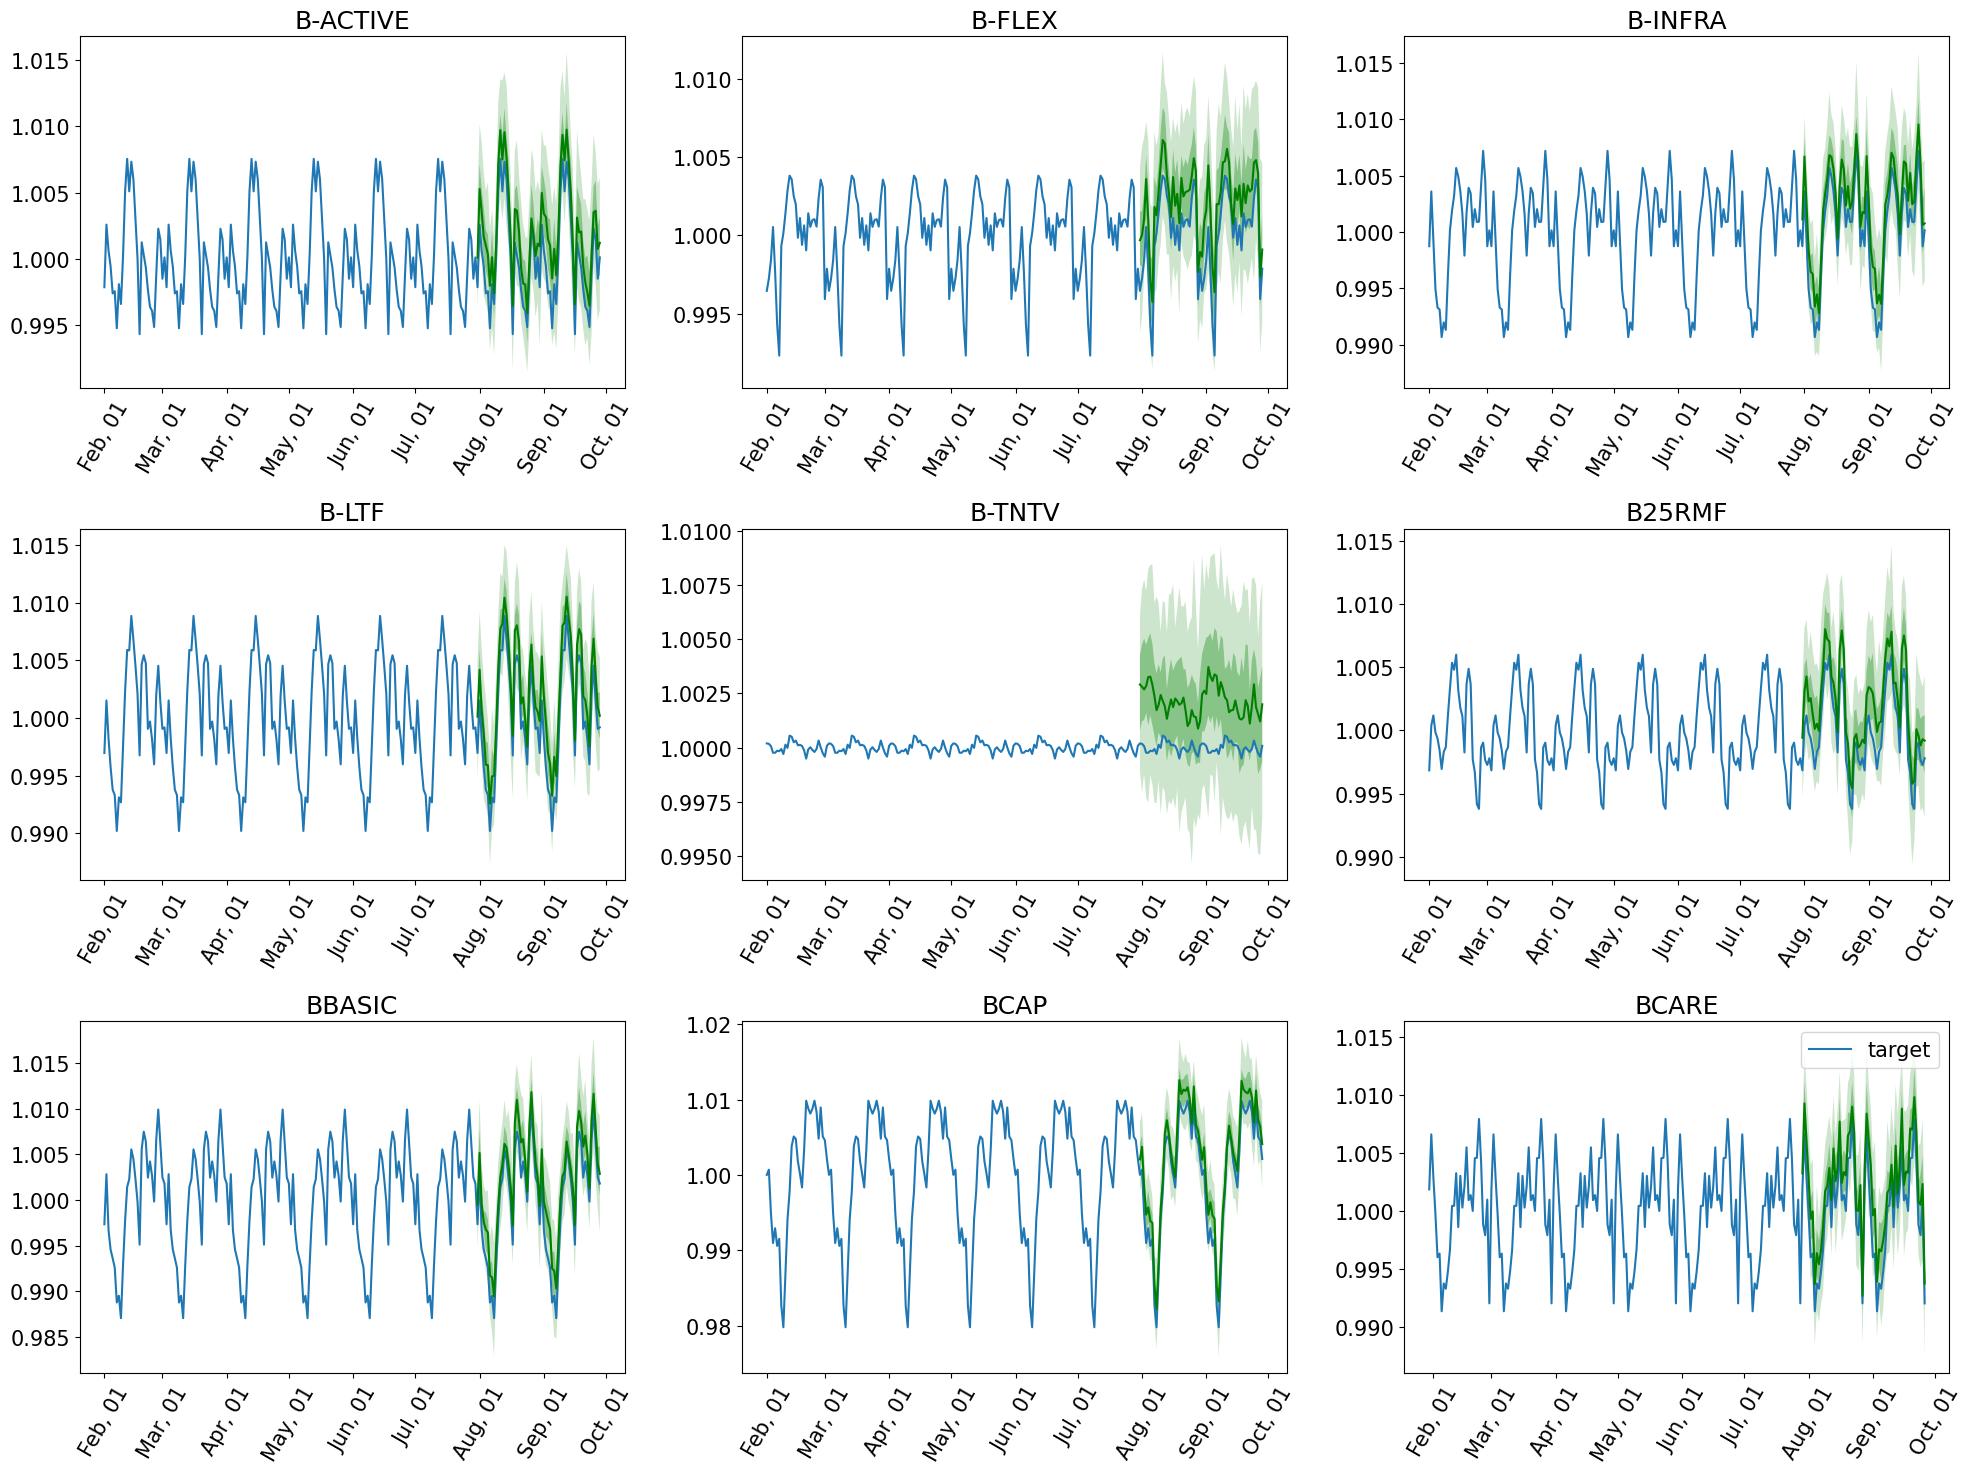

In [27]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * 60:].to_timestamp(), label="target", )
    forecast.plot(color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()